In [24]:
# Импорт библиотек
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'png'

In [26]:
# Загрузка датасета
df = pd.read_csv('DiZyme_jan2022.csv')
df.head()

,formula,activity,surface,Km,Kcat,Vmax,Syngony,length,width,depth,...,temp,Cper,Csub,Ccat,Dstr,mX,mROx,mCD,volume,link
0,CoFe2O4,peroxidase,naked,0.00645,12 306.4508003,1.3763,7.0,4.1,4.1,4.1,...,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304,68.92,https://doi.org/10.1039/C4RA15675G
1,CoFe2O4,peroxidase,naked,0.05537,2 363.2892149,0.2643,7.0,13.8,13.8,13.8,...,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304,2628.07,https://doi.org/10.1039/C4RA15675G
2,CoFe2O4,peroxidase,naked,0.03551,74 779.3708079,8.3630,7.0,4.1,4.1,4.1,...,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304,68.92,https://doi.org/10.1039/C4RA15675G
3,CoFe2O4,peroxidase,naked,0.22769,3 918.2494665,0.4382,7.0,13.8,13.8,13.8,...,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304,2628.07,https://doi.org/10.1039/C4RA15675G
4,CoFe2O4,peroxidase,naked,0.01725,9 184.9060976,1.0272,7.0,24.5,24.5,24.5,...,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304,14706.13,https://doi.org/10.1039/C4RA15675G


In [27]:
# Удаление ненужных строчек (пустых)
df = df.iloc[:303]

In [28]:
# Удаление ненужного столбца
df.drop('link', axis=1, inplace=True)

In [29]:
# Проверка на null значения
df.isna().any()

formula     False
activity    False
surface     False
Km          False
Kcat         True
Vmax         True
Syngony     False
length      False
width       False
depth       False
pol         False
surf        False
Subtype     False
ph          False
temp        False
Cper        False
Csub        False
Ccat        False
Dstr        False
mX          False
mROx        False
mCD         False
volume      False
dtype: bool

<AxesSubplot:>

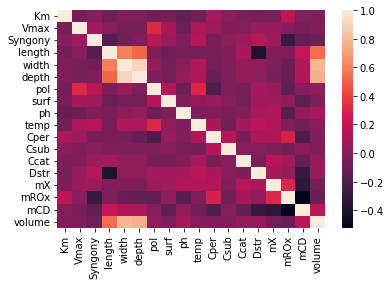

In [30]:
# Постройка корреляционной матрицы
corr = df.corr()
sns.heatmap(data=corr)

In [31]:
# На выброс претендуют:
# 1) Depth;
# 2) Width;
# 3) Length.
# Т.к. параметр Volume хорошо их описывает

df.drop(['depth', 'length', 'width'], axis=1, inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   formula   303 non-null    object 
 1   activity  303 non-null    object 
 2   surface   303 non-null    object 
 3   Km        303 non-null    float64
 4   Kcat      301 non-null    object 
 5   Vmax      302 non-null    float64
 6   Syngony   303 non-null    float64
 7   pol       303 non-null    float64
 8   surf      303 non-null    float64
 9   Subtype   303 non-null    object 
 10  ph        303 non-null    float64
 11  temp      303 non-null    float64
 12  Cper      303 non-null    float64
 13  Csub      303 non-null    float64
 14  Ccat      303 non-null    float64
 15  Dstr      303 non-null    float64
 16  mX        303 non-null    float64
 17  mROx      303 non-null    float64
 18  mCD       303 non-null    float64
 19  volume    303 non-null    float64
dtypes: float64(15), object(5)
memory

In [33]:
# Kcat не должен быть формата 'object'. Исправляем:

set([type(i) for i in df['Kcat'].values])

{float, str}

In [34]:
df['Kcat'] = df['Kcat'].apply(lambda x: str(x).replace(' ', '')).astype('float64')

In [35]:
# Как очистить данные от пропусков?
# Во-первых, строк с отсутствующими данными очень мало.
len(df) - len(df.dropna())

2

In [36]:
# Так что можно их выбросить. Тогда мы потеряем:
print(round(2 / len(df) * 100, 4), '%', sep='')

0.6601%


In [37]:
# Можно заполнить модой
# df.fillna(df.mode(), inplace=True)

In [38]:
# Но если есть цель как можно точнее заполнить
# недостающие данные, то можно просто обучить модель:

# Будем предполагать, что недостающие значения
# есть только в столбцах 'Km', 'Kcat', 'Vmax'.
# Иначе будет долгая и муторная реализация

from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor


def fillna_with_model(df_):
    df = df_.copy()

    if not df.isna().any().any():
        return

    # Кодируем object-значения
    cols_to_encode = ['formula', 'activity', 'surface', 'Subtype']
    encoders = dict([
        (col, LabelEncoder().fit(df[col])) for col in cols_to_encode
    ])

    encoded = df.copy()

    for col, enc in encoders.items():
        encoded[col] = enc.transform(encoded[col])

    # Готовим обучающие данные.
    # Берём все строчки, которые не имеют пустот.

    valid = encoded.dropna()
    pred_cols = ['Km', 'Kcat', 'Vmax']
    train, target = valid.drop(pred_cols, axis=1), valid.filter(pred_cols)

    # Обучаем модель
    model = MultiOutputRegressor(XGBRegressor()).fit(train, target)

    # Предсказываем
    x = encoded.drop(pred_cols, axis=1)
    pred = model.predict(x)

    # Замещаем
    corrupted = np.where(df.isna().any(axis=1))[0]

    for i in corrupted:
        df.loc[i, pred_cols] = pred[i]

    return df

In [39]:
df = fillna_with_model(df)

Chisquare for column "formula":
Power_divergenceResult(statistic=2.537627030029737, pvalue=1.0)


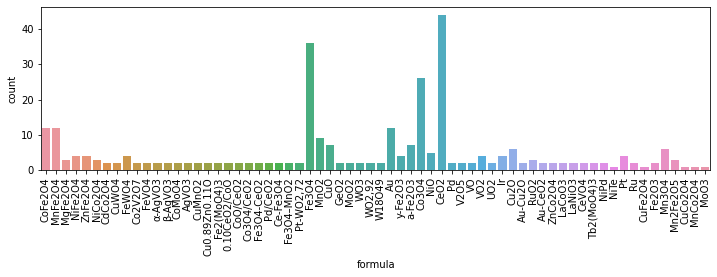

Chisquare for column "activity":
Power_divergenceResult(statistic=1.3430709407574422, pvalue=0.5109234673339882)


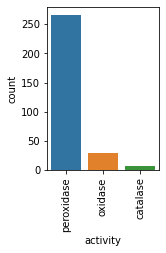

Chisquare for column "surface":
Power_divergenceResult(statistic=13.905564813907132, pvalue=0.8352515444301921)


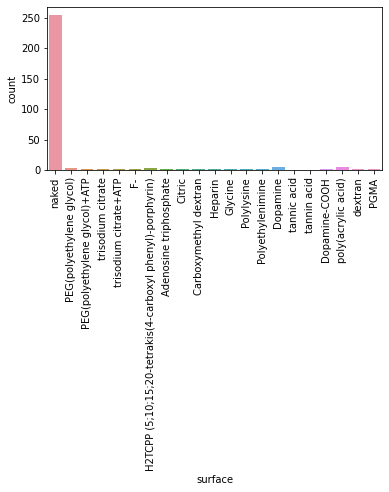

Chisquare for column "Subtype":
Power_divergenceResult(statistic=2.9888246250367603, pvalue=0.964736385794407)


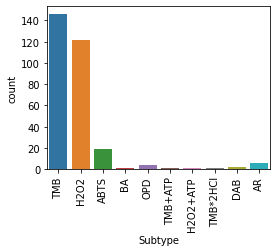

In [40]:
# Хи-квадрат

from scipy.stats import chisquare

for col in df.columns:
    if df[col].dtype != 'object':
        continue
    counts = df[col].value_counts(normalize=True)
    print(f'Chisquare for column "{col}":')
    print(chisquare(counts.values))
    plt.figure(figsize=(int(len(counts) ** 0.5 * 1.5), 3))
    sns.countplot(data=df, x=col)
    _ = plt.xticks(rotation=90)
    plt.show()

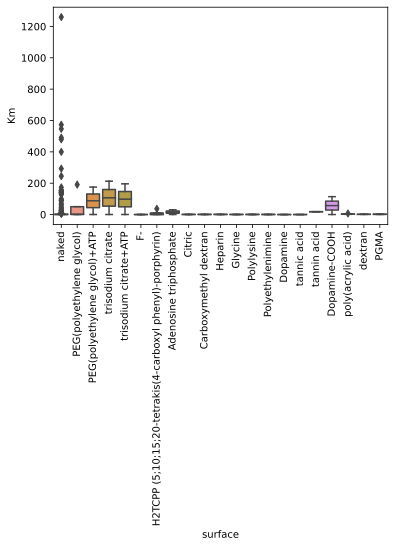

In [480]:
# Посмотрим на зависимость типа поверхности
# от параметра Km
sns.boxplot(data=df, x='surface', y='Km')
_ = plt.xticks(rotation=90)

In [481]:
# Не смотрим на множество точек в категории "naked", т.к. почти все значения там находятся около нуля.
# PEG, PEG + ATP, trisodium citrate, trisodium citrate + ATP, Dopamite + COOH поверхности
# дают довольно большие показатели параметра Km.

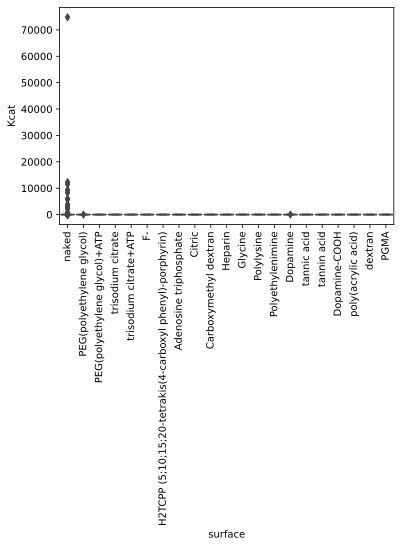

In [482]:
# Посмотрим на зависимость типа поверхности
# от параметра Kcat
sns.boxplot(data=df, x='surface', y='Kcat')
_ = plt.xticks(rotation=90)

In [483]:
# Ничего интересного

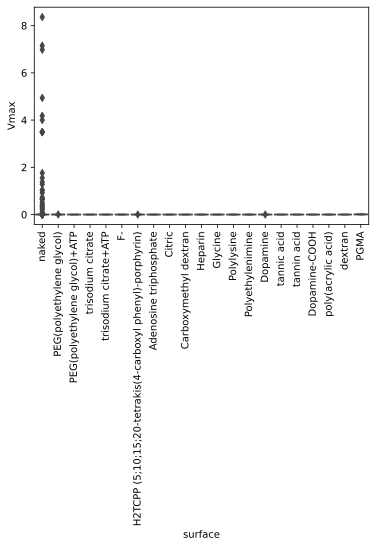

In [484]:
# То же самое только с параметром Vmax
sns.boxplot(data=df, x='surface', y='Vmax')
_ = plt.xticks(rotation=90)

In [485]:
# Опять же нет зависимости.

<AxesSubplot:xlabel='activity', ylabel='Km'>

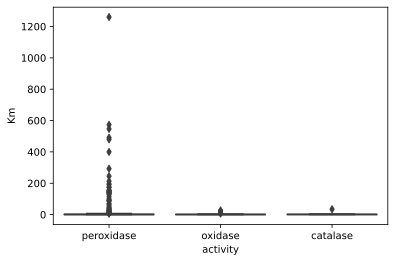

In [486]:
# Смотрим зависимость между параметром "activity"
# и целевыми переменными
sns.boxplot(data=df, x='activity', y='Km')

<AxesSubplot:xlabel='activity', ylabel='Kcat'>

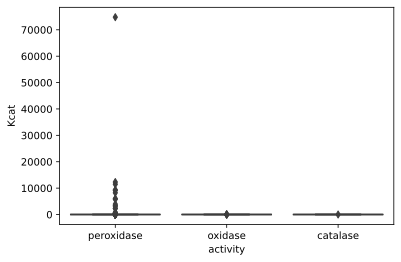

In [487]:
sns.boxplot(data=df, x='activity', y='Kcat')

<AxesSubplot:xlabel='activity', ylabel='Vmax'>

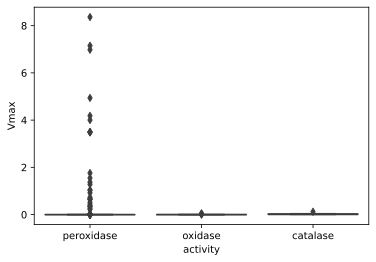

In [488]:
sns.boxplot(data=df, x='activity', y='Vmax')

In [489]:
# Ничего примечательного.

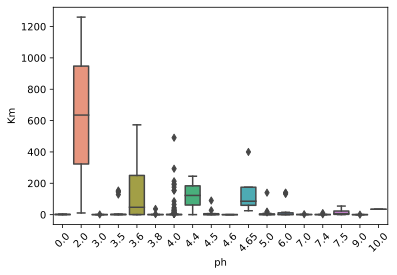

In [490]:
# Проверим, как кислотность (Ph) влияет на параметры
sns.boxplot(data=df, x='ph', y='Km')
_ = plt.xticks(rotation=45)

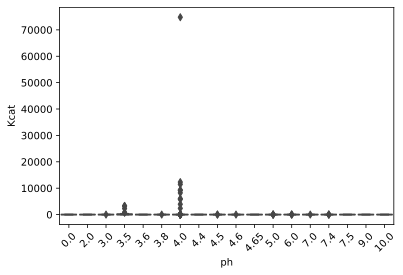

In [491]:
sns.boxplot(data=df, x='ph', y='Kcat')
_ = plt.xticks(rotation=45)

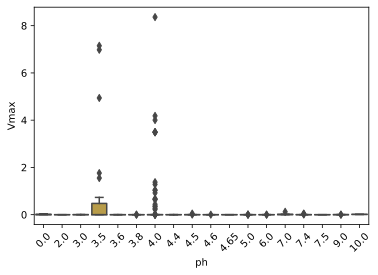

In [492]:
sns.boxplot(data=df, x='ph', y='Vmax')
_ = plt.xticks(rotation=45)

In [493]:
# Стоит сказать, что при PH == 4.0 все переменные иногда повышаются до очень больших значений.
# PH == 3.5 влияет на параметр Vmax
# PH == 2.0, 3.6, 4.4 и 4.65 особо влияет на параметр Km.

<AxesSubplot:xlabel='Dstr', ylabel='Km'>

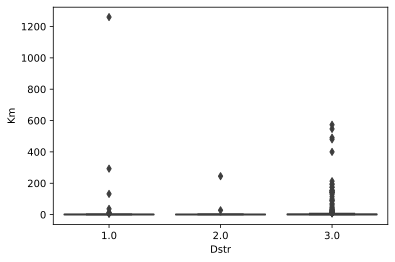

In [494]:
sns.boxplot(data=df, x='Dstr', y='Km')

<AxesSubplot:xlabel='Dstr', ylabel='Kcat'>

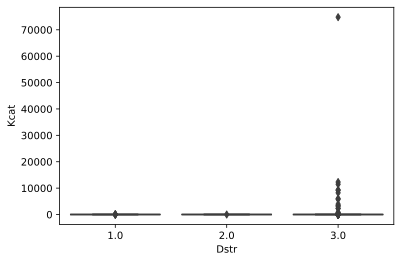

In [495]:
sns.boxplot(data=df, x='Dstr', y='Kcat')

<AxesSubplot:xlabel='Dstr', ylabel='Vmax'>

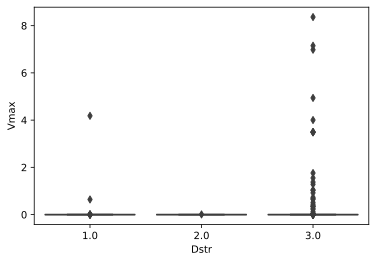

In [496]:
sns.boxplot(data=df, x='Dstr', y='Vmax')

In [497]:
df['Dstr'].value_counts(normalize=True)

3.0    0.825083
1.0    0.138614
2.0    0.036304
Name: Dstr, dtype: float64

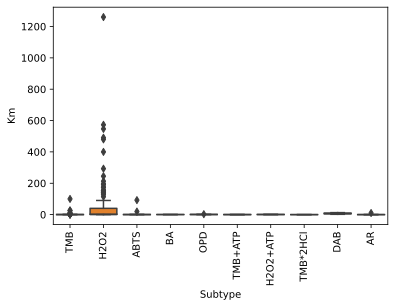

In [498]:
# Посмотрим, как система, в которой проводился эксперимент,
# влияет на показания параметров Km, Kcat, Vmax
sns.boxplot(data=df, x='Subtype', y='Km')
_ = plt.xticks(rotation=90)

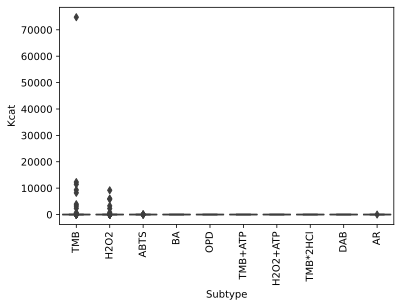

In [499]:
sns.boxplot(data=df, x='Subtype', y='Kcat')
_ = plt.xticks(rotation=90)

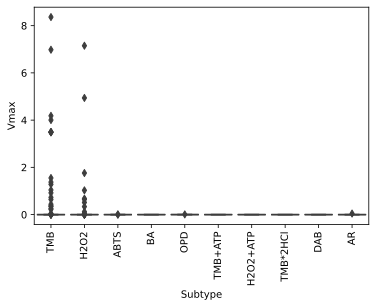

In [500]:
sns.boxplot(data=df, x='Subtype', y='Vmax')
_ = plt.xticks(rotation=90)

In [501]:
df['Subtype'].value_counts(normalize=True)

TMB         0.481848
H2O2        0.402640
ABTS        0.062706
AR          0.019802
OPD         0.013201
DAB         0.006601
BA          0.003300
TMB+ATP     0.003300
H2O2+ATP    0.003300
TMB*2HCl    0.003300
Name: Subtype, dtype: float64

In [502]:
# Отметим, что при использовании H2O2 параметр Km резко повышается.
# Остальные параметры в среднем выше при использовании H2O2 и TMB, но 
# это объясняется их преобладанием в датасете

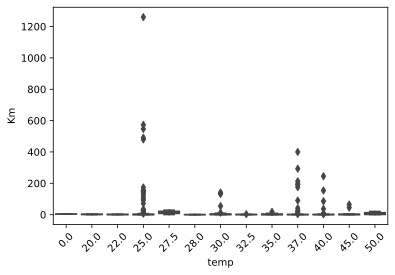

In [503]:
# Посмотрим, как температура влияет на главные параметры
sns.boxplot(data=df, x='temp', y='Km')
_ = plt.xticks(rotation=45)

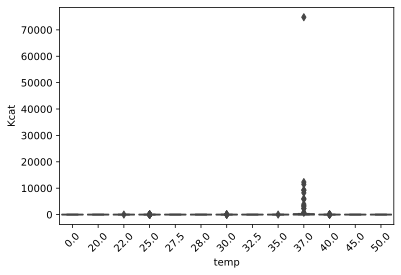

In [504]:
sns.boxplot(data=df, x='temp', y='Kcat')
_ = plt.xticks(rotation=45)

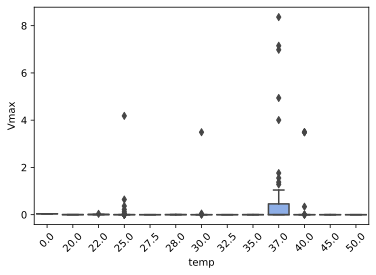

In [505]:
sns.boxplot(data=df, x='temp', y='Vmax')
_ = plt.xticks(rotation=45)

In [506]:
# Как видим, для увеличения параметра Vmax (да и других тоже) хорошо подходит температура в районе 37 градусов;
# Параметры Vmax и Km при температуре 25.0 тоже в среднем становятся больше.

<AxesSubplot:xlabel='surf', ylabel='Km'>

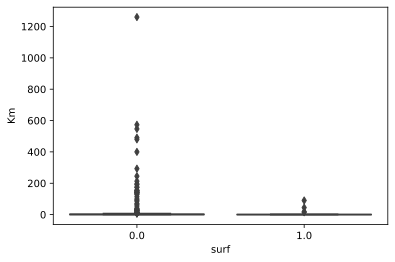

In [507]:
# Определим влияние параметра Surf на главные параметры
sns.boxplot(data=df, x='surf', y='Km')

<AxesSubplot:xlabel='surf', ylabel='Kcat'>

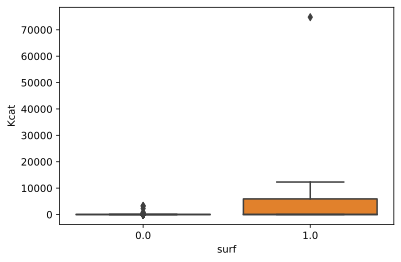

In [508]:
sns.boxplot(data=df, x='surf', y='Kcat')

<AxesSubplot:xlabel='surf', ylabel='Vmax'>

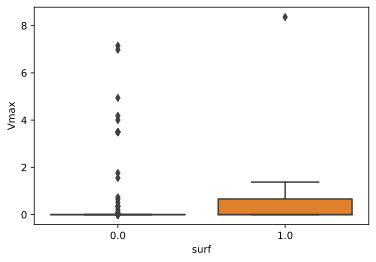

In [509]:
sns.boxplot(data=df, x='surf', y='Vmax')

In [510]:
# Surf == 1.0 на Kcat и Vmax действует сильнее, чем на Km
# Surf == 0 у Vmax и Km часто вызывает появляние больших значений

<AxesSubplot:xlabel='pol', ylabel='Vmax'>

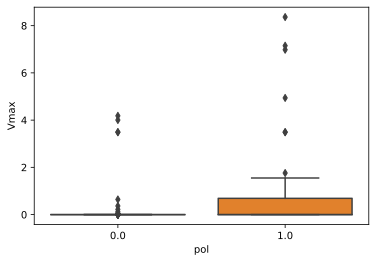

In [511]:
# Значение параметра Pol на параметры:
sns.boxplot(data=df, x='pol', y='Vmax')

<AxesSubplot:xlabel='pol', ylabel='Km'>

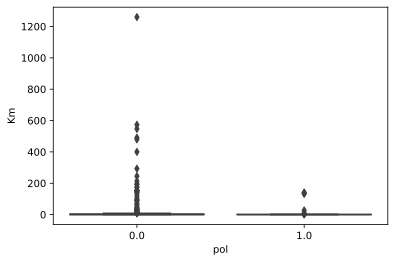

In [512]:
sns.boxplot(data=df, x='pol', y='Km')

<AxesSubplot:xlabel='pol', ylabel='Kcat'>

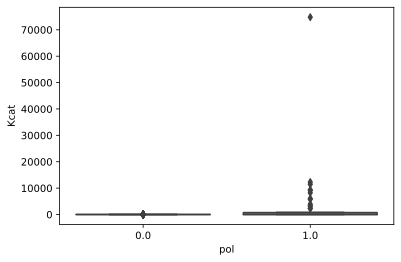

In [513]:
sns.boxplot(data=df, x='pol', y='Kcat')

In [514]:
# Pol == 1 у Kat иногда вызывает появление больших значений, как и Pol == 0 у Km

<AxesSubplot:xlabel='Syngony', ylabel='Km'>

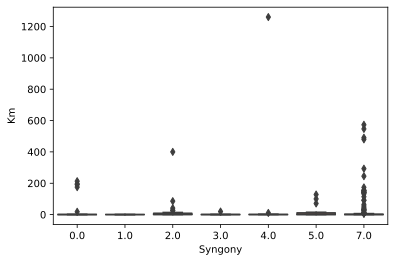

In [515]:
# Смотрим параметр Syngony
sns.boxplot(data=df, x='Syngony', y='Km')

<AxesSubplot:xlabel='Syngony', ylabel='Kcat'>

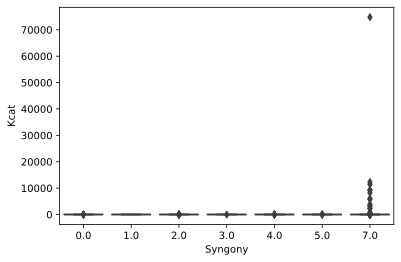

In [516]:
sns.boxplot(data=df, x='Syngony', y='Kcat')

<AxesSubplot:xlabel='Syngony', ylabel='Vmax'>

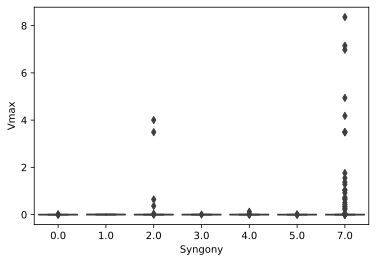

In [517]:
sns.boxplot(data=df, x='Syngony', y='Vmax')

In [518]:
df['Syngony'].value_counts(normalize=True)

7.0    0.646865
2.0    0.115512
4.0    0.089109
0.0    0.072607
5.0    0.046205
3.0    0.023102
1.0    0.006601
Name: Syngony, dtype: float64

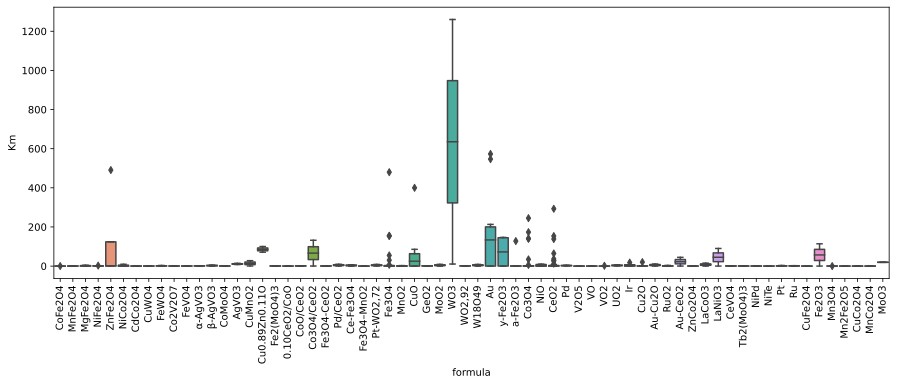

In [519]:
# Проверим, как формула НЧ влияет на главные параметры
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='formula', y='Km')
_ = plt.xticks(rotation=90)

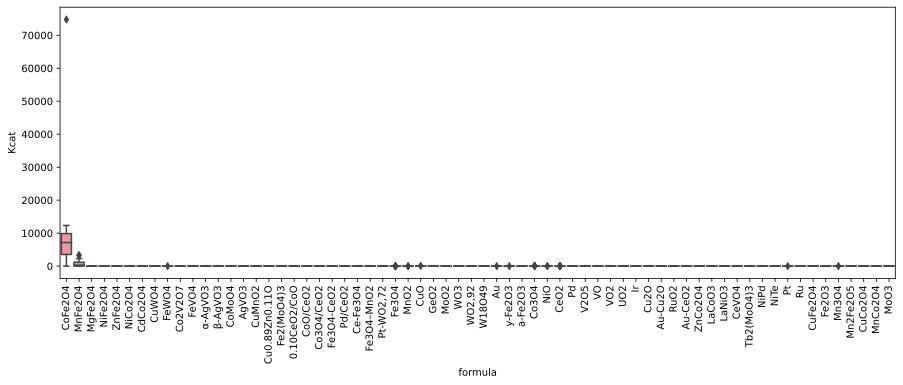

In [520]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='formula', y='Kcat')
_ = plt.xticks(rotation=90)

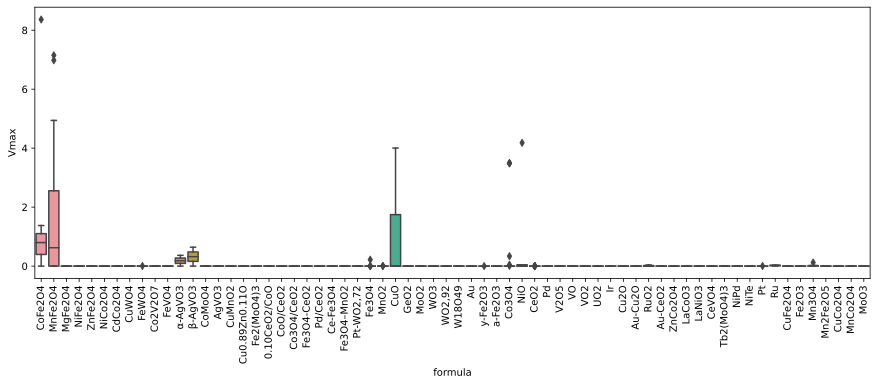

In [521]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='formula', y='Vmax')
_ = plt.xticks(rotation=90)

In [522]:
df['formula'].value_counts(normalize=True)

CeO2       0.145215
Fe3O4      0.118812
Co3O4      0.085809
CoFe2O4    0.039604
Au         0.039604
             ...   
NiTe       0.003300
CuFe2O4    0.003300
CuCo2O4    0.003300
MnCo2O4    0.003300
MoO3       0.003300
Name: formula, Length: 66, dtype: float64

In [523]:
# Учитываем, что каждая формула не занимает больше 15% от всех формул!

# WO3, Au, y-Fe2O3, LaNiO3, Fe2O3, ZnFe2O4 сильно влияют на параметр Km, в особенности WO3
# CoFe2O4 сильно влияют на параметр Kcat
# Cuo, CoFe2O4, MnFe2O4, alpha-AgVO3, beta-AgVO3 сильно влияют на параметр Vmax

In [657]:
df.head()

,formula,activity,surface,Km,Kcat,Vmax,Syngony,length,width,pol,...,Subtype,ph,temp,Cper,Csub,Ccat,Dstr,mX,mROx,mCD
0,CoFe2O4,peroxidase,naked,0.00645,12306.450800,1.3763,7.0,4.1,4.1,1.0,...,TMB,4.0,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304
1,CoFe2O4,peroxidase,naked,0.05537,2363.289215,0.2643,7.0,13.8,13.8,1.0,...,TMB,4.0,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304
2,CoFe2O4,peroxidase,naked,0.03551,74779.370808,8.3630,7.0,4.1,4.1,1.0,...,TMB,4.0,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304
3,CoFe2O4,peroxidase,naked,0.22769,3918.249466,0.4382,7.0,13.8,13.8,1.0,...,TMB,4.0,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304
4,CoFe2O4,peroxidase,naked,0.01725,9184.906098,1.0272,7.0,24.5,24.5,1.0,...,H2O2,4.0,37.0,100.0,15.0,0.02624,3.0,2.77,-0.1585,0.0304


In [41]:
df2_enc = df.drop(['formula'], axis=1)

for col in df2_enc.columns:
    if df2_enc[col].dtype == 'object':
        lenc = LabelEncoder().fit(df2_enc[col])
        df2_enc[col] = lenc.transform(df2_enc[col])

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

x, y = df2_enc.drop(['Km', 'Kcat'], axis=1), df2_enc['Km']

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

<BarContainer object of 17 artists>

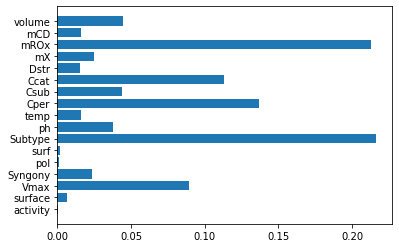

In [65]:
rfr = RandomForestRegressor().fit(x_train, y_train)

plt.barh(x.columns, rfr.feature_importances_)

In [66]:
rfr.score(x_test, y_test)

-0.0024992773982965844

In [733]:
df2_num = df.select_dtypes(include=np.number)

In [743]:
# Визуализация и разделение на 3 группы 

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

t = TSNE(n_components=2).fit_transform(df2_enc)

In [756]:
cl = DBSCAN(eps=2.8).fit_predict(t)
cl

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 1, 1, 2, 2, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 2,
       1, 1, 1, 1, 1, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0,

In [757]:
dft = pd.DataFrame(t)
dft.rename({
    0: 'x',
    1: 'y',
    2: 'z'
}, inplace=True, axis=1)
dft['group'] = cl
dft.head()

,x,y,group
0,-17.919544,11.079524,0
1,-16.469387,10.603058,0
2,-18.219700,10.701503,0
3,-16.688465,10.731524,0
4,-4.367784,2.693794,0


In [758]:
import plotly.express as px

In [759]:
fig = px.scatter(dft, x='x', y='y', color='group')
fig.show()

In [651]:
# действительно 3 группы)